In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import datetime

In [2]:
train_df = pd.read_csv('train.csv', parse_dates=['date'])
test_df = pd.read_csv('test.csv', parse_dates=['date'])
result_df = pd.read_csv('result_df.csv', parse_dates= ['date'])
store_df =pd.read_csv('stores.csv')

holiday_df = pd.read_csv('holidays_events.csv', parse_dates= ['date'] )
holiday_df['weekday'] = [n.isoweekday() for n in holiday_df['date']]
national = holiday_df[ (holiday_df['locale'] == 'National')&(holiday_df['transferred'] == False)]

prod_list = list(train_df.family.unique())
store_list = list(store_df.store_nbr.unique())

In [3]:
# dropping days with zero sales (the ones zero from 2013-01-01) - store opened later
result_df.drop(index = result_df[(result_df['store_nbr'] == 20) & (result_df['date'] < '2015-02-13')].index, inplace = True)
result_df.drop(index = result_df[(result_df['store_nbr'] == 21) & (result_df['date'] < '2015-07-24')].index, inplace = True)
result_df.drop(index = result_df[(result_df['store_nbr'] == 22) & (result_df['date'] < '2015-10-09')].index, inplace = True)
result_df.drop(index = result_df[(result_df['store_nbr'] == 29) & (result_df['date'] < '2015-03-20')].index, inplace = True)
result_df.drop(index = result_df[(result_df['store_nbr'] == 36) & (result_df['date'] < '2013-05-09')].index, inplace = True)
result_df.drop(index = result_df[(result_df['store_nbr'] == 42) & (result_df['date'] < '2015-08-21')].index, inplace = True)
result_df.drop(index = result_df[(result_df['store_nbr'] == 52) & (result_df['date'] < '2017-04-20')].index, inplace = True)
result_df.drop(index = result_df[(result_df['store_nbr'] == 53) & (result_df['date'] < '2015-05-29')].index, inplace = True)

In [4]:
# adding lag
def lag(feature, length):
    final_series = pd.Series()
    for f in all_df[ 'family' ].unique():
        filtered = all_df.loc[all_df[ 'family' ] == f]
        for nr in all_df[ 'store_nbr' ].unique():
            filtered2 = filtered.loc[all_df[ 'store_nbr' ] == nr]
            lagged_series = filtered2[ feature ].shift(length)  
            final_series = pd.concat([final_series, lagged_series])
    all_df[f'lag_{feature}_{length}'] = final_series

# adding days
def add_days(database):
    database['weekday'] = [n.isoweekday() for n in database['date']]
    database = pd.get_dummies(database, columns=['weekday'])
    return database

# estimation
def run_rgr_date(*args, date = '2017-08-16'):
    arg_list = list(args)
    pred_test_acc = np.empty((0,1))

    for nr in store_list:
        filtered = all_df.loc[all_df['store_nbr'] == nr]
        for f in prod_list:
            filtered_2 = filtered.loc[all_df[ 'family' ] == f]
     
            X_test = filtered_2.loc[filtered_2['date'] == date, arg_list]
            if X_test.shape ==  (0, len(args)):
                continue

            CV_index_dropped = filtered_2.drop(index = X_test.index)
            X_train = CV_index_dropped[arg_list].values
            y_train = CV_index_dropped['sales'].values.reshape(-1, 1)
            
            X_test = X_test.values    
            
            scaler = StandardScaler()
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_test  = scaler.transform(X_test)

            rgr = linear_model.LinearRegression()
            rgr.fit(X_train, y_train)
            pred_test = rgr.predict(X_test)

            pred_test_acc = np.concatenate((pred_test_acc, pred_test)).reshape(-1, 1)     

    # not allowing negative amounts in the prediction
    pred_test_acc[pred_test_acc < 0] = 0

    return pred_test_acc

,Unnamed: 0,id,date,store_nbr,family,sales,onpromotion
2778991,2754125,3011443,2017-08-21,54,POULTRY,54.736023,0
2778992,2755805,3011444,2017-08-21,54,PREPARED FOODS,93.366496,0
2778993,2757485,3011445,2017-08-21,54,PRODUCE,629.241349,0
2778994,2759165,3011446,2017-08-21,54,SCHOOL AND OFFICE SUPPLIES,0.381150,0
2778995,2760845,3011447,2017-08-21,54,SEAFOOD,1.385993,0


In [15]:
pred_dates = ['2017-08-27', '2017-08-28', '2017-08-29','2017-08-30', '2017-08-31']
for pred_date in pred_dates:
    test_df_add = test_df[test_df['date']  == pred_date]
    all_df = pd.concat([result_df, test_df_add]).reset_index()
    all_df.drop(columns =['index'], inplace= True)
    all_df.sort_values(by = ['store_nbr', 'family'], inplace = True)

    all_df['weekday'] = all_df['date'].apply(lambda x: x.isoweekday())

    complete_date_range = pd.DataFrame()
    complete_date_range['date'] = pd.date_range(start=all_df['date'].min(), end=all_df['date'].max(),freq='D')
    complete_date_range['time'] = complete_date_range.index
    all_df = pd.merge(all_df, complete_date_range, how = 'left', on ='date')

    lag('sales', 1)
    lag('sales', 7)
    lag('sales', 14)
    lag_with_na = [n for n in all_df.columns if n.startswith('lag')]
    all_df.dropna(subset= lag_with_na, inplace= True)

    all_df = add_days(all_df)

    all_df = pd.merge(all_df, national[['date', 'transferred']], on = 'date', how = 'left')
    all_df = all_df.rename( columns={ 'transferred' : 'holiday'})
    all_df['holiday'] = np.where(all_df['holiday'] == False, True, False)

    x = run_rgr_date('time', 'lag_sales_1', 'lag_sales_7', 'lag_sales_14',  'onpromotion',
                    'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',  'weekday_6', 'weekday_7', 'holiday',  date = pred_date)

    sales_day = all_df[all_df['date'] == pred_date]
    sales_day['sales'] = x
    result_df = pd.concat([result_df, sales_day[['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion']]])



C:\Users\bokuhu01\AppData\Local\Temp\1\ipykernel_10112\954490150.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_day['sales'] = x
C:\Users\bokuhu01\AppData\Local\Temp\1\ipykernel_10112\954490150.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_day['sales'] = x
C:\Users\bokuhu01\AppData\Local\Temp\1\ipykernel_10112\954490150.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [16]:
result_df.date.unique()

<DatetimeArray>
['2013-01-01 00:00:00', '2013-01-02 00:00:00', '2013-01-03 00:00:00',
 '2013-01-04 00:00:00', '2013-01-05 00:00:00', '2013-01-06 00:00:00',
 '2013-01-07 00:00:00', '2013-01-08 00:00:00', '2013-01-09 00:00:00',
 '2013-01-10 00:00:00',
 ...
 '2017-08-22 00:00:00', '2017-08-23 00:00:00', '2017-08-24 00:00:00',
 '2017-08-25 00:00:00', '2017-08-26 00:00:00', '2017-08-27 00:00:00',
 '2017-08-28 00:00:00', '2017-08-29 00:00:00', '2017-08-30 00:00:00',
 '2017-08-31 00:00:00']
Length: 1700, dtype: datetime64[ns]

In [3]:
def create_plot(database, group, filter):
    CV_grouped = database[database['date'] > '2017-07-31']
    CV_grouped = CV_grouped.groupby(by =[group, 'date'])[['sales']].sum().loc[filter]
    
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(CV_grouped.index, CV_grouped['sales'], label = 'actual')
    ax.set_title('CV_plot')
    ax.legend()
    ax.tick_params(axis='x', rotation=90)

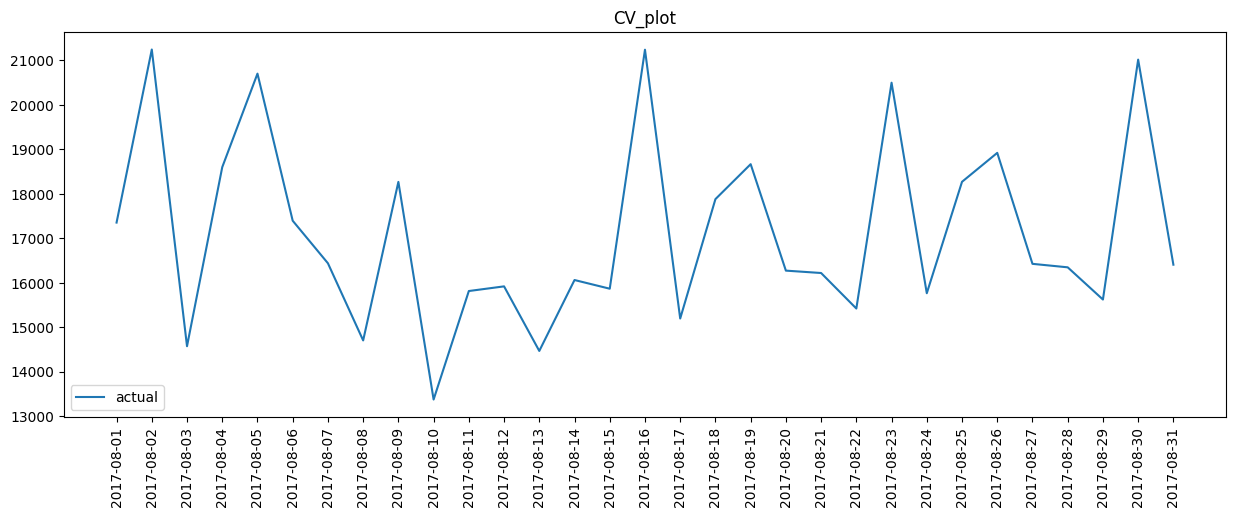

In [25]:
create_plot(result_df, 'store_nbr', 24)

In [9]:
submission = pd.merge(test_df, result_df[['date', 'store_nbr', 'family', 'sales']], on = ['date', 'store_nbr', 'family'], how = 'left')

In [8]:
zero_check = train_df[('2017-07-31'< train_df['date']) & (train_df['date'] < '2017-08-16')]
zero_check = zero_check.groupby(by = ['store_nbr', 'family'])['sales'].sum().reset_index()
zero_check = zero_check[(zero_check['sales'] == 0)] 
zero_check

,store_nbr,family,sales
1,1,BABY CARE,0.0
4,1,BOOKS,0.0
17,1,HOME APPLIANCES,0.0
31,1,SCHOOL AND OFFICE SUPPLIES,0.0
34,2,BABY CARE,0.0
...,...,...,...
1753,54,BOOKS,0.0
1768,54,LADIESWEAR,0.0
1769,54,LAWN AND GARDEN,0.0
1775,54,PET SUPPLIES,0.0


In [16]:
zero_check.rename(columns = {'sales' : 'zero_pred'}, inplace = True)
submission = pd.merge(submission, zero_check, on = ['store_nbr', 'family'], how = 'left')
submission['sales'] = np.where(submission['zero_pred'] == 0, 0, submission['sales'])
submission.drop(columns = ['zero_pred'], inplace = True)

In [17]:

submission = submission[['id', 'sales']]
submission.to_csv('submission_2.csv', index= False)